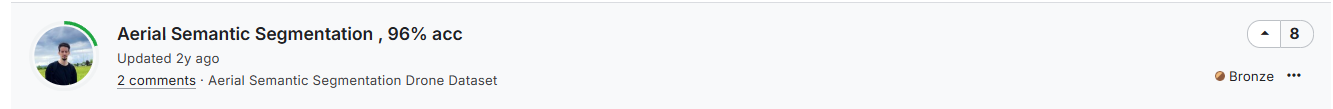

In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras import regularizers

In [8]:
import os 
import numpy as np 
import pandas as pd 
import imageio 
import matplotlib.pyplot as plt 
%matplotlib inline 

path =r'D:\code_study\ML_CODE\dataSets\Segmentation\Aerial_Semantic_Segmentation_Drone_Dataset\archive\dataset\semantic_drone_dataset/'
path = path.replace("\\", "/")
image_path = os.path.join(path,'original_images/')
mask_path = os.path.join(path,'label_images_semantic/')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]
image_list = sorted(image_list)
mask_list = sorted(mask_list)
train_image_list = image_list[:390]
train_mask_list = mask_list[:390]

validation_image_list = image_list[390:400]
validation_mask_list = mask_list[390:400]

print("number of train images is : {} ".format(len(train_image_list)))
print("number of train masks is : {} ".format(len(train_mask_list)))

print("number of train images is : {} ".format(len(validation_image_list)))
print("number of train masks is : {} ".format(len(validation_mask_list)))

print(image_list[0])
print(mask_list[0])

number of train images is : 390 
number of train masks is : 390 
number of train images is : 10 
number of train masks is : 10 
D:/code_study/ML_CODE/dataSets/Segmentation/Aerial_Semantic_Segmentation_Drone_Dataset/archive/dataset/semantic_drone_dataset/original_images/000.jpg
D:/code_study/ML_CODE/dataSets/Segmentation/Aerial_Semantic_Segmentation_Drone_Dataset/archive/dataset/semantic_drone_dataset/label_images_semantic/000.png


c:\Users\Leaper\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  
c:\Users\Leaper\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  after removing the cwd from sys.path.


(4000, 6000, 3)
(4000, 6000)


Text(0.5, 1.0, 'Mask')

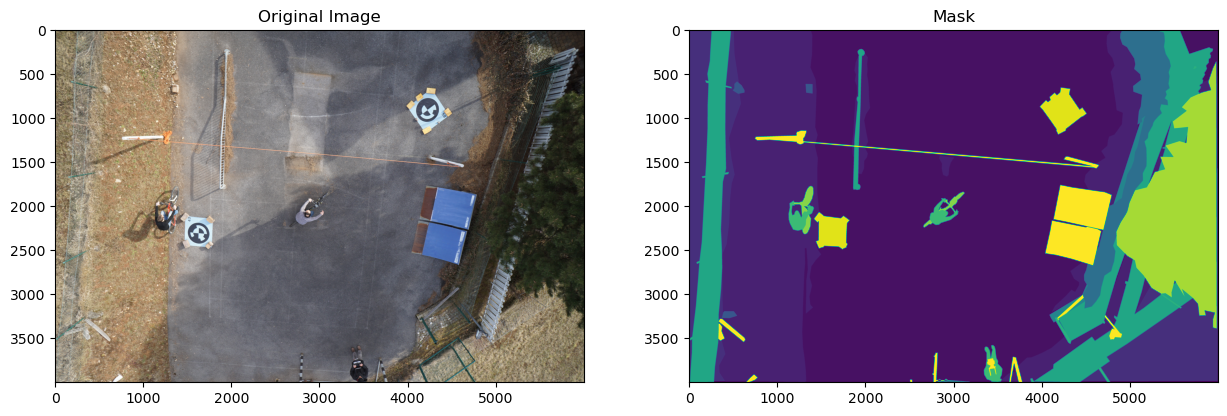

In [9]:
n = 10 # you can chose any index 
img  = imageio.imread(train_image_list[n])
print(img.shape)
mask = imageio.imread(train_mask_list[n])
print(mask.shape)

# now let's plot 
fig ,arr  = plt.subplots(1,2,figsize=(15,10))
arr[0].imshow(img)
arr[0].set_title('Original Image')
arr[1].imshow(mask)
arr[1].set_title('Mask')

In [10]:
train_images = tf.constant(train_image_list)
train_masks = tf.constant(train_mask_list)

train_dataset = tf.data.Dataset.from_tensor_slices((train_images,train_masks))
for image,mask in train_dataset.take(1) : 
    print(image)
    print(mask)
    
validation_images = tf.constant(validation_image_list)
validation_masks = tf.constant(validation_mask_list)

validation_dataset = tf.data.Dataset.from_tensor_slices((validation_images,validation_masks))
for image,mask in validation_dataset.take(1) : 
    print(image)
    print(mask)   

tf.Tensor(b'D:/code_study/ML_CODE/dataSets/Segmentation/Aerial_Semantic_Segmentation_Drone_Dataset/archive/dataset/semantic_drone_dataset/original_images/000.jpg', shape=(), dtype=string)
tf.Tensor(b'D:/code_study/ML_CODE/dataSets/Segmentation/Aerial_Semantic_Segmentation_Drone_Dataset/archive/dataset/semantic_drone_dataset/label_images_semantic/000.png', shape=(), dtype=string)
tf.Tensor(b'D:/code_study/ML_CODE/dataSets/Segmentation/Aerial_Semantic_Segmentation_Drone_Dataset/archive/dataset/semantic_drone_dataset/original_images/586.jpg', shape=(), dtype=string)
tf.Tensor(b'D:/code_study/ML_CODE/dataSets/Segmentation/Aerial_Semantic_Segmentation_Drone_Dataset/archive/dataset/semantic_drone_dataset/label_images_semantic/586.png', shape=(), dtype=string)


In [12]:
def process_path(image_path,mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img,channels=3)
    img = tf.image.convert_image_dtype(img,tf.float32) #this do the same as dividing by 255 to set the values between 0 and 1 (normalization)
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask,channels=3)
    mask = tf.math.reduce_max(mask,axis=-1,keepdims=True)
    return img , mask

def preprocess(image,mask) : 
    input_image = tf.image.resize(image,(96,128),method='nearest')
    input_mask = tf.image.resize(mask,(96,128),method='nearest')
    
    return input_image , input_mask

train_image_ds = train_dataset.map(process_path) # apply the preprocces_path function to our train_dataset
print(train_image_ds)
train_processed_image_ds = train_image_ds.map(preprocess) # apply the preprocess function to our train_dataset

validation_image_ds = validation_dataset.map(process_path) # apply the preprocces_path function to our validation_dataset
print(validation_image_ds)
validation_processed_image_ds = validation_image_ds.map(preprocess) 

<MapDataset shapes: ((None, None, 3), (None, None, 1)), types: (tf.float32, tf.uint8)>
<MapDataset shapes: ((None, None, 3), (None, None, 1)), types: (tf.float32, tf.uint8)>


In [13]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    
    conv = Conv2D(n_filters, 
                  kernel_size = 3,     
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(inputs)
    conv = Conv2D(n_filters, 
                  kernel_size = 3, 
                  activation='relu',
                  padding='same',
                  kernel_initializer=tf.keras.initializers.HeNormal())(conv)
   
    

    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
        
    if max_pooling:
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
        
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [14]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    
    up = Conv2DTranspose(
                 n_filters,  
                 kernel_size = 3,
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,  
                 kernel_size = 3,   
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(merge)
    conv = Conv2D(n_filters,  
                 kernel_size = 3,  
                 activation='relu',
                 padding='same',
                 kernel_initializer=tf.keras.initializers.HeNormal())(conv)
    
    
    return conv

In [15]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    
    inputs = Input(input_size)
    
    # contracting path
    cblock1 = conv_block(inputs, n_filters, dropout_prob=0.4)
    cblock2 = conv_block(cblock1[0], 2*n_filters, dropout_prob=0.4)
    cblock3 = conv_block(cblock2[0], 4*n_filters, dropout_prob=0.4)
    cblock4 = conv_block(cblock3[0], 8*n_filters, dropout_prob=0.45) 
    cblock5 = conv_block(cblock4[0],16*n_filters, dropout_prob=0.4, max_pooling=None)     
    
    # expanding path
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  8 * n_filters)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters*4)
    ublock8 = upsampling_block(ublock7,cblock2[1] , n_filters*2)
    ublock9 = upsampling_block(ublock8,cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)
    
    conv10 = Conv2D(n_classes, kernel_size=1, padding='same')(conv9)  
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [16]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [17]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 128, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 128, 32)  896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 128, 32)  9248        conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 96, 128, 32)  0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [18]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
EPOCHS = 500
VAL_SUBSPLITS = 5
BUFFER_SIZE = 390
BATCH_SIZE = 16

# train
train_processed_image_ds.batch(BATCH_SIZE)
train_dataset = train_processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(train_processed_image_ds.element_spec)

# validation
validation_processed_image_ds.batch(BATCH_SIZE)
validation_dataset = validation_processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(validation_processed_image_ds.element_spec)
 

model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/500
25/25 [==============================] - 102s 163ms/step - loss: 4.2276 - accuracy: 0.1746
Epoch 2/500
25/25 [==============================] - 2s 79ms/step - loss: 2.2049 - accuracy: 0.4021
Epoch 3/500
25/25 [==============================] - 2s 79ms/step - loss: 2.1167 - accuracy: 0.3955
Epoch 4/500
25/25 [==============================] - 2s 79ms/step - loss: 1.8858 - accuracy: 0.4908
Epoch 5/500
25/25 [==============================] - 2s 79ms/step - loss: 1.7814 - accuracy: 0.5174
Epoch 6/500
25/25 [==============================] - 2s 79ms/step - loss: 1.7186 - accuracy: 0.5355
Epoch 7/500
25/25 [==============================] - 2s 79ms/step - loss: 1.6207 - accuracy: 0.5441
Epoch 8/500
25/25 [==============================] - 2s

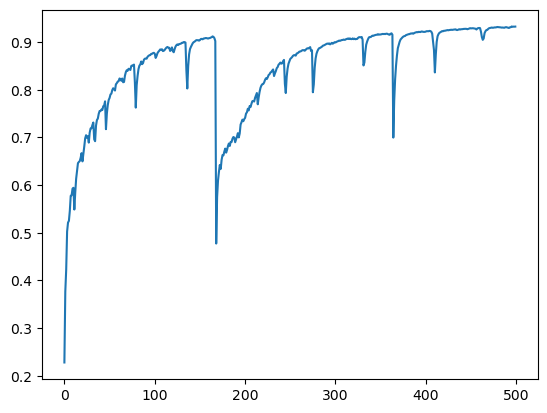

In [20]:
plt.plot(model_history.history["accuracy"])

In [21]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [22]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [23]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

----- training_dataset results---------


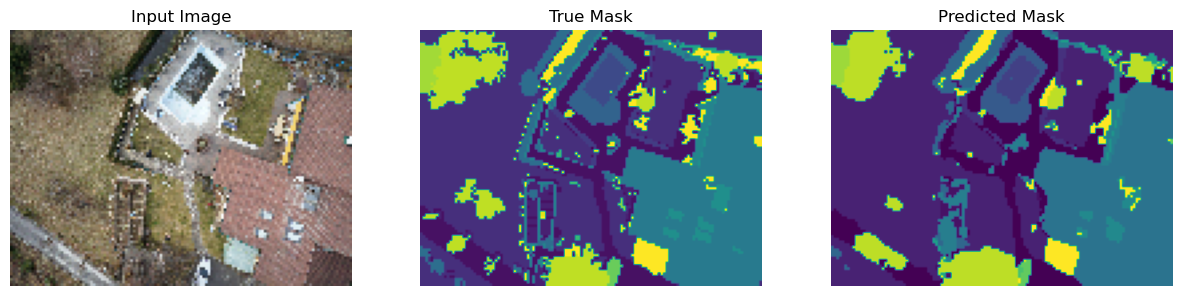

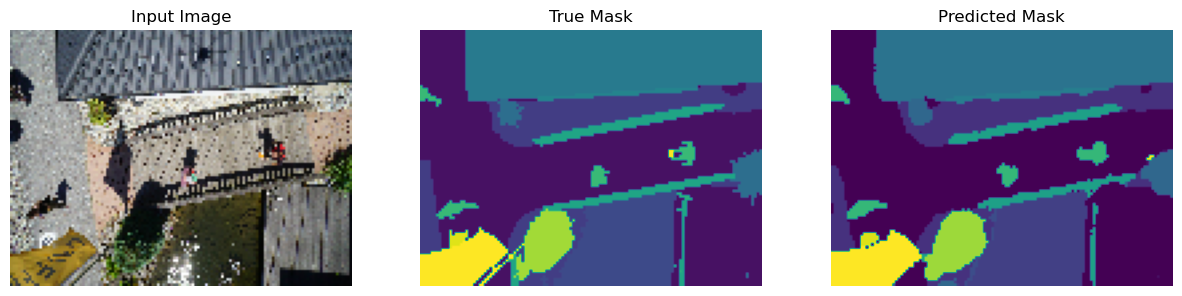

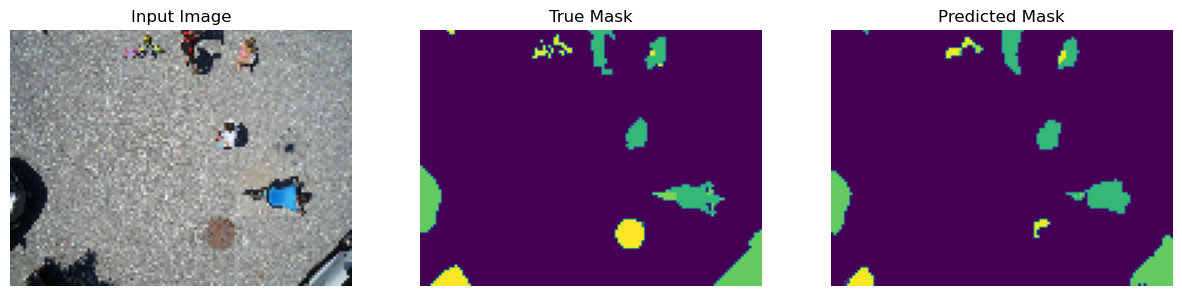

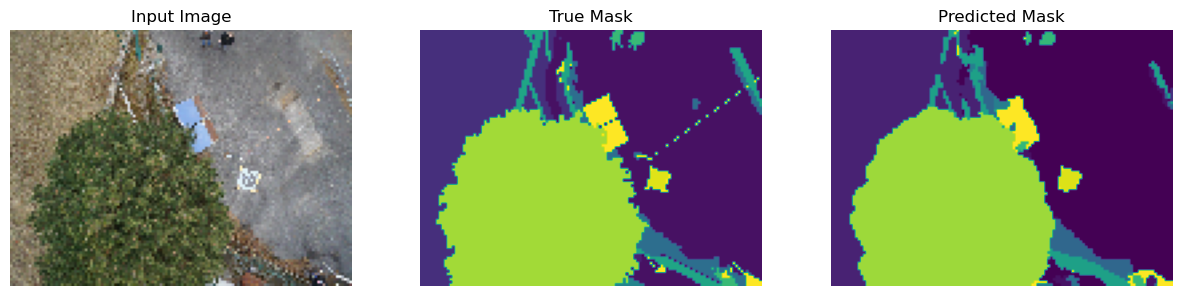

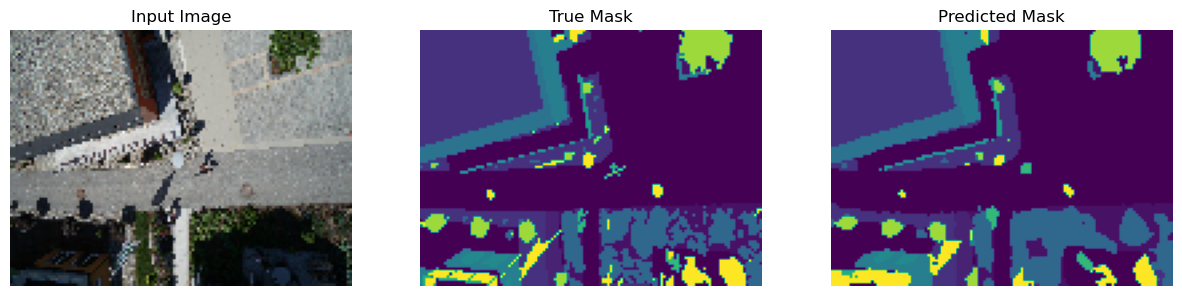

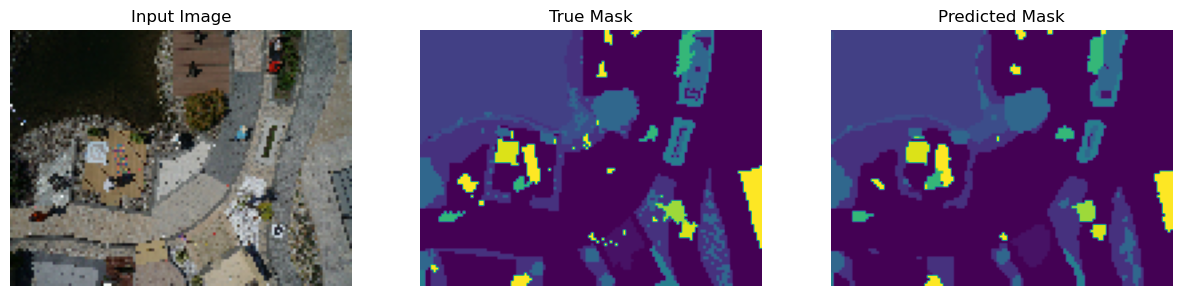

----- validation_dataset results---------


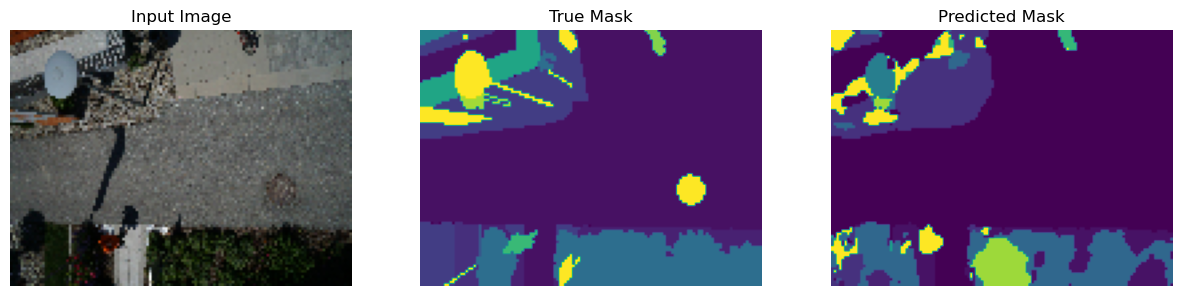

In [24]:
print("----- training_dataset results---------")
show_predictions(train_dataset, 6)
print("----- validation_dataset results---------")
show_predictions(validation_dataset, 6)

In [25]:
# model evaluation
print("Unet Model Evaluation: ")
unet.evaluate(validation_dataset)

Unet Model Evaluation: 
1/1 [==============================] - 0s 331ms/step - loss: 0.4538 - accuracy: 0.8771


[0.4538227617740631, 0.8770507574081421]